# RandomForest on mel-spectrogram summarization

This is very close to the `melspec-maxp` (max summarization) baseline model in [Automatic large-scale classification of bird sounds is strongly improved by unsupervised feature learning](https://peerj.com/articles/488/) (Dan Stowell, Mark D. Plumbley)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time

import numpy
import pandas
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics

# Custom modules
import dcase2018bird
import features

# Load dataset

In [2]:
dataset = dcase2018bird.load_dataset()
print(dataset.shape)
dataset.head(3)

(48310, 4)


,itemid,datasetid,hasbird,folder
0,BUK4_20161103_204504_125,PolandNFC,NaN,polandnfc
1,BUK4_20161016_012704_132,PolandNFC,NaN,polandnfc
2,6wichura_deszcz_BUK4_20161005_022304_129,PolandNFC,NaN,polandnfc


In [3]:
dataset.datasetid.unique()

array(['PolandNFC', 'BirdVox-DCASE-20k', 'chern', 'ff1010bird',
       'warblrb10k', 'wabrlrb10k_test'], dtype=object)

## Extract smaller dataset


In [4]:
with_labels = dataset[dataset.hasbird.notna()].copy()
with_labels['hasbird'] = with_labels.hasbird.astype(bool)

trainset = with_labels.groupby('datasetid').apply(lambda g: g.sample(n=1000, random_state=1))
trainset.shape, trainset.datasetid.unique()
#trainset.groupby('folder').head(1)

((3000, 4),
 array(['BirdVox-DCASE-20k', 'ff1010bird', 'warblrb10k'], dtype=object))

In [5]:
trainset.to_csv('data/train3x1k.csv')

In [8]:
# download to disk
def download_url(url, to='data/3x1k'):
    import urllib
    import os.path
    
    if not os.path.exists(to):
        os.mkdir(to)
        
    tok = url.split('/')
    folder = tok[-2]
    itemid, ext = os.path.splitext(tok[-1])
    #print('f', folder, itemid, ext)
    # store flat
    outpath = os.path.join(to, "{}-{}".format(folder, itemid+ext))
    with urllib.request.urlopen(url) as r:
        with open(outpath, 'wb') as f:
            f.write(r.read())
            
    return outpath

featureset = 'melspec-htk-b64-fmin500-fmax15000'
feature_urls = dcase2018bird.feature_urls(trainset, featureset)

feature_images = [ download_url(u) for u in feature_urls ]
print(feature_images[0:3])

['data/3x1k/birdvox-9317fa13-0959-456a-aca0-343b227c6a1a.png', 'data/3x1k/birdvox-d38908fa-9afc-4552-a076-98544ffd83eb.png', 'data/3x1k/birdvox-29cca49a-587b-4ad4-a77a-66e4f0b5c750.png']


In [9]:
trainset['filename'] = feature_images

In [107]:
def build_model(img_shape):
    from keras.applications import mobilenet_v2
    model = mobilenet_v2.MobileNetV2(weights='imagenet',
                           input_shape=(img_shape[0], img_shape[1], 3),
                           include_top=False, pooling='avg')
    preprocess_input = mobilenet_v2.preprocess_input
    return model, preprocess_input
  
image_shape = (96, 96)
MobileNet = build_model(image_shape)

9412608/9406464 [==============================] - 4s 0us/step


In [108]:
MobileNet[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [ ]:
import keras
def calculate_features(model, img_path, img_shape):
    model, preprocess_input = model
    
    img_h, img_w = img_shape
    img = keras.preprocessing.image.load_img(img_path, color_mode='rgb',
                                             target_size=(img_h, 850))
    
    arr = keras.preprocessing.image.img_to_array(img)
    
    #print('a', arr.shape)
    pieces = []
    hop_size = 85
    for i in range(0, 850//hop_size):
       start = i*hop_size
       wanted_end = start+img_w
       end = min(wanted_end, arr.shape[1])
       p = arr[:,start:end,:]
       #print('p', p.shape, wanted_end-end)
       p = numpy.pad(p, ((0,0),(0,wanted_end-end),(0,0)), mode='constant')
       pieces.append(p)
    
    samples = numpy.stack(pieces)
    samples = preprocess_input(samples)
    #print('p', samples.mean(), samples.std())
    f = model.predict(samples)
    #print('f', f.shape)
    return f

start = time.time()
m_features = [ calculate_features(MobileNet, f, image_shape) for f in trainset.filename ]
print('t', time.time()-start)

In [29]:
numpy.savez('data/mobilenet-10split-96', m_features)

In [58]:
def train_logreg(X, y):
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import LogisticRegression
  from sklearn.ensemble import RandomForestClassifier

  random_state = 42
    
  X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.33, random_state=random_state)
  estimator = LogisticRegression(solver='lbfgs', C=0.001, random_state=random_state, max_iter=100)
  #estimator = RandomForestClassifier(n_estimators=100, max_depth=5)
  estimator.fit(X_train, y_train)
  
  train_loss = sklearn.metrics.log_loss(y_train, estimator.predict_proba(X_train))
  train_acc = sklearn.metrics.accuracy_score(y_train, estimator.predict(X_train))
  print('train loss={:.2f} accuracy={:.1f}%'.format(train_loss, train_acc*100))
  
  val_loss = sklearn.metrics.log_loss(y_val, estimator.predict_proba(X_val))
  val_acc = sklearn.metrics.accuracy_score(y_val, estimator.predict(X_val))
  print('val   loss={:.2f} accuracy={:.1f}%'.format(val_loss, val_acc*100))

  return estimator

scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(m_features)
X = m_features
y_ = trainset.hasbird
logreg = train_logreg(X, y_)


train loss=0.48 accuracy=78.1%
val   loss=0.51 accuracy=76.8%


# Load features

In [137]:
import skimage.io

mel_summary_columns = ['max', 'mean', 'std']
mel_summary_shape = (len(mel_summary_columns),64)

def rmse(x, axis=None):
    return numpy.sqrt(numpy.mean(x**2, axis=axis))

def mel_summary(url):
    mel = skimage.io.imread(url)
    scale = rmse(mel, axis=0)
    mel = mel / scale
    
    features = numpy.vstack([
        numpy.max(mel, axis=1),
        numpy.mean(mel, axis=1),
        numpy.std(mel, axis=1),
    ])
    assert features.shape == mel_summary_shape, features.shape
    return features

#F = features.extract(dcase2018bird.feature_urls(dataset, featureset)[0:10], mel_summary, mel_summary_shape)
#F.compute().shape

(10, 3, 64)

In [142]:
start = time.time()
FF = features.extract(dcase2018bird.feature_urls(trainset, featureset)[0:1000], mel_summary, mel_summary_shape)
train_X = FF.compute()
train_X = train_X[:,0]
train_Y = trainset[0:1000].hasbird
end = time.time()
print('d', end-start)

d 154.7076117992401


### Compute features

# Model

In [150]:
rf = make_pipeline(
    RandomForestClassifier(n_estimators=100, min_samples_leaf=2, random_state=1),
)

X_train, X_test, Y_train, Y_test = \
  model_selection.train_test_split(train_X, train_Y, test_size=0.3)

start = time.time()
print('Starting train', X_train.shape, numpy.mean(Y_train))
rf.fit(X_train, Y_train)
end = time.time()
print('Train time', end-start)

print('train', model_selection.cross_val_score(rf, X_train, Y_train, scoring='accuracy', cv=5))
print('test', model_selection.cross_val_score(rf, X_test, Y_test, scoring='accuracy', cv=5))


Starting train (700, 64) 0.5128571428571429
Train time 1.224815845489502
train [0.71631206 0.7        0.67857143 0.69285714 0.67625899]
test [0.68333333 0.75       0.6        0.71666667 0.7       ]


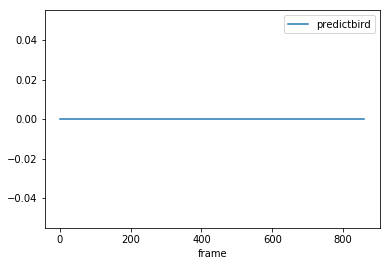

In [148]:
import urllib, io, scipy.io.wavfile, librosa

def read_audio(url):
    f = urllib.request.urlopen(url)
    data = io.BytesIO(f.read())
    samplerate, samples  = scipy.io.wavfile.read(data)
    assert samplerate == 44100, samplerate
    data = samples.astype('float')/32768
    return samplerate, data

def melspec(data, sr, subtract='median', n_mels=64, fmin=500, fmax=15000, htk=True,):
    from librosa.feature import melspectrogram
    
    mel = melspectrogram(y=data, sr=sr,
                         n_mels=n_mels, fmin=fmin, fmax=fmax, htk=True)
    mel = librosa.core.amplitude_to_db(mel, ref=1.0)

    if not subtract:
        pass #disabled
    elif subtract == 'mean':
        mel = mel - (numpy.mean(mel, axis=1, keepdims=True) + 1e-8)
    elif subtract == 'median':
        mel = mel - (numpy.median(mel, axis=1, keepdims=True) + 1e-8)
    else:
        raise ValueError('Unsupported subtract={}'.format(subtract))

    return mel


def quantize_8bit(s):
    out_min,out_max  = 0, 255
    in_min, in_max = s.min(), s.max()
    std = (s - in_min) / (in_max - in_min)
    scaled = std * (out_max - out_min) + out_min
    return scaled.astype(numpy.uint8)

def run_detector(estimator, mel, detector_window = 5):

    frame_starts = list(range(0, mel.shape[1], detector_window))
    predictions = []
    means = []
    for frame_start in frame_starts:
        frames = mel[:,frame_start:frame_start+detector_window]
        f = numpy.max(frames, axis=1)
        
        has_bird = estimator.predict([f])[0]
        predictions.append(has_bird)
        means.append(f.mean())
        
    df = pandas.DataFrame({
        'predictbird': numpy.array(predictions).astype(int),
        'frame': frame_starts,
        'm': means, 
    })
    return df


#warblr = dataset[dataset.datasetid == 'warblrb10k']
#print(len(warblr))
#warblr_withbird = warblr[warblr.hasbird == True]
example_url = list(dcase2018bird.wav_urls(trainset))[100]
sr, samples = read_audio(example_url)
mel = melspec(samples, sr)
mel = quantize_8bit(mel)
run_detector(rf, mel).plot(y='predictbird', x='frame')

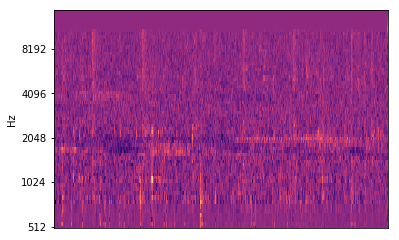

In [122]:
import IPython.display
import librosa.display
librosa.display.specshow(mel, y_axis='mel', fmin=500, fmax=15000, sr=sr)

IPython.display.Audio(example_url)